In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve, make_moons, make_swiss_roll
import torch
import torch.nn as nn
%matplotlib inline

In [2]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():
    devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [3]:
myDevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', myDevice)
print(try_all_gpus())

Using device: cpu
[device(type='cpu')]


### 数据集生成

In [4]:
def get_curve_dateset(curve='s_curve', n_samples=10000, noise=0.1):
    if curve =='s_curve':
        curve, _ = make_s_curve(n_samples=n_samples, noise=noise)
        curve = curve[:, [0, 2]]
    elif curve == 'moons':
        curve, _ = make_moons(n_samples=n_samples, noise=noise)
    elif curve == 'swiss_roll':
        curve, _ = make_swiss_roll(n_samples=n_samples, noise=noise)
        curve = curve[:, [0, 2]]
    else:
        raise NotImplementedError(curve)
    print("shape of curve:", np.shape(curve))

    plt.scatter(*curve.T, color='k', edgecolors='gray')
    plt.axis('off')
    dataset = torch.tensor(curve, device=myDevice).float()
    return dataset

shape of curve: (10000, 2)


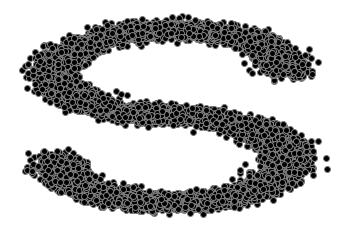

In [5]:
curve = 's_curve'
n_samples = 10000
noise = 0.1
dataset = get_curve_dateset(curve, n_samples, noise)

In [6]:
def get_beta_schedule(schedule='linear', start=1e-4, end=2e-2, steps=1000):
    if schedule == 'linear':
        betas = torch.linspace(start, end, steps)
    elif schedule == 'quad':
        betas = torch.linspace(start ** 0.5, end ** 0.5, steps) ** 2
    elif schedule == 'sigmoid':
        betas = torch.linspace(-6, 6, steps)
        betas = torch.sigmoid(betas) * (end - start) + start
    else:
        raise NotImplementedError(schedule)
    assert betas.shape == (steps,)
    return betas.to(myDevice)

### 超参数设置

In [7]:
num_steps = torch.tensor(100,device=myDevice)
schedule = 'sigmoid'
betas = get_beta_schedule(schedule, start=1e-5, end=0.5e-2, steps=num_steps)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)
alphas_bar_sqrt = torch.sqrt(alphas_bar)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_bar)

assert alphas.shape == alphas_bar.shape == alphas_bar_sqrt.shape \
    == one_minus_alphas_bar_sqrt.shape

print("all the same shape:",alphas.shape)

all the same shape: torch.Size([100])


### 正向加噪声

In [8]:
def q_sample(x_start, t, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    x_t = alphas_bar_sqrt[t] * x_start + one_minus_alphas_bar_sqrt[t] * noise
    return x_t

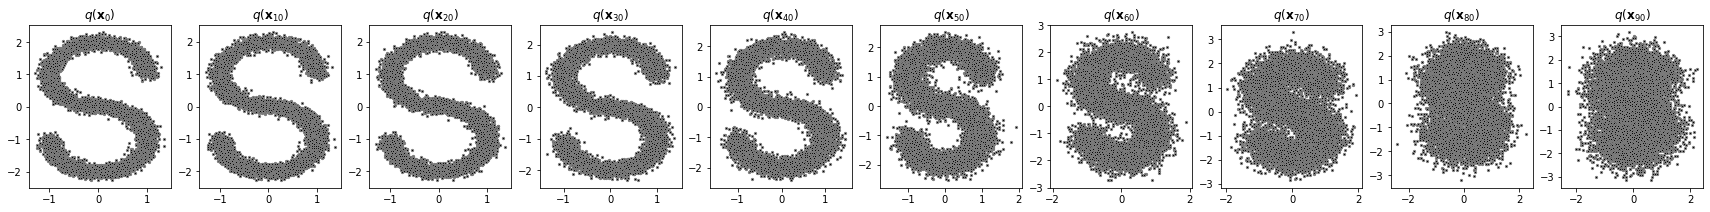

In [9]:
num_shows = 10
fig, axs = plt.subplots(1, 10,figsize=(30, 3))
plt.rc('text',color='blue')

for i in range(num_shows):
    q_i = q_sample(dataset, torch.tensor([i * 10],device=myDevice), alphas_bar_sqrt, one_minus_alphas_bar_sqrt).cpu()
    axs[i].scatter(q_i[:, 0], q_i[:, 1], color='k',edgecolor='gray', s=5)
    #axs[i].set_axis_off()
    axs[i].set_title('$q(\mathbf{x}_{' + str(i * 10)+'})$')

In [10]:

class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()

        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units,device=myDevice),
                nn.ReLU(),
                nn.Linear(num_units, num_units,device=myDevice),
                nn.ReLU(),
                nn.Linear(num_units, num_units,device=myDevice),
                nn.ReLU(),
                nn.Linear(num_units, 2,device=myDevice),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units,device=myDevice),
                nn.Embedding(n_steps, num_units,device=myDevice),
                nn.Embedding(n_steps, num_units,device=myDevice),
            ]
        )

    def forward(self, x, t):
        for idx, embedding_layer in enumerate(self.step_embeddings):
            x = self.linears[2 * idx](x)
            x += embedding_layer(t)
            x = self.linears[2 * idx + 1](x)
        x = self.linears[-1](x)
        return x

In [11]:
def diffusion_loss(model, x_start, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    batch_size = x_start.shape[0]

    t = torch.randint(0, n_steps, size=(batch_size//2,),device=myDevice)
    t = torch.cat([t, n_steps - 1 - t], dim=0)[:batch_size].long()
    eps = torch.randn_like(x_start,device=myDevice)
    x_t = q_sample(x_start, t.unsqueeze(-1), alphas_bar_sqrt, one_minus_alphas_bar_sqrt, noise=eps)
    eps_theta = model(x_t, t)
    loss = torch.nn.MSELoss()

    return loss(eps, eps_theta)

In [12]:
def p_sample(model, x_t, t, betas, one_minus_alphas_bar_sqrt):

    t = torch.tensor([t],device=myDevice)
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x_t, t)
    mean = (1 /(1 - betas[t]).sqrt()) * (x_t - coeff * eps_theta)
    if t > 1:
        z = torch.randn_like(x_t,device=myDevice)
    else:
        z = torch.zeros_like(x_t,device=myDevice)

    sigma_t = betas[t].sqrt()
    sample = mean + sigma_t * z
    return sample


def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):

    cur_x = torch.randn(shape,device=myDevice)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq = [cur_x] + x_seq
    return x_seq

In [13]:
import pytorch_fid.fid_score as FID

def calculate_fid(pred, gt):
  mu1, sigma1 = pred.mean(axis=0), np.cov(pred, rowvar=False)
  mu2, sigma2 = gt.mean(axis=0), np.cov(gt, rowvar=False)
  fid = FID.calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
  return fid

epoch:100, loss:1.082720, fid:0.229397
epoch:200, loss:0.605064, fid:0.216891
epoch:300, loss:1.083602, fid:0.234598
epoch:400, loss:0.910887, fid:0.225754
epoch:500, loss:1.376794, fid:0.227329
epoch:600, loss:0.764673, fid:0.225673
epoch:700, loss:0.714693, fid:0.218453
epoch:800, loss:0.480019, fid:0.220350
epoch:900, loss:0.695756, fid:0.223190
epoch:1000, loss:0.627988, fid:0.247359


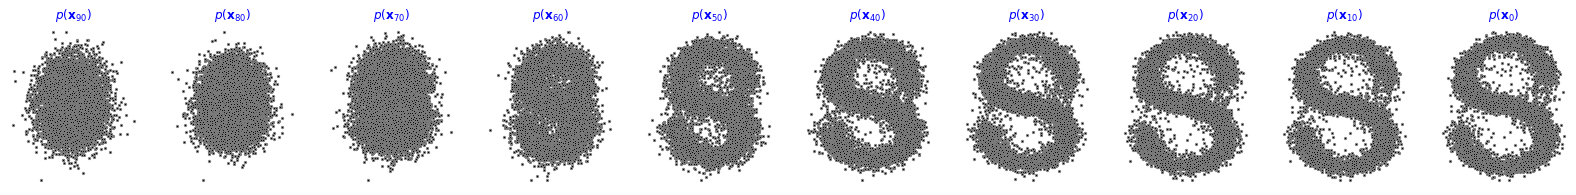

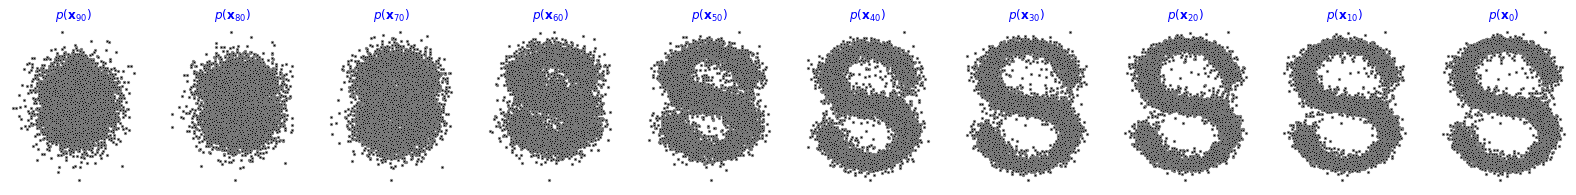

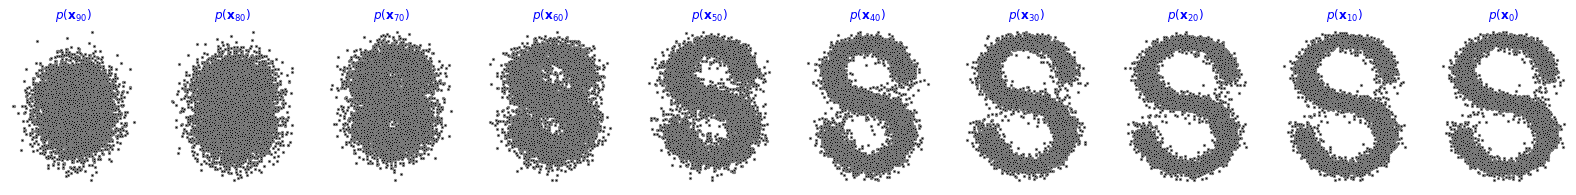

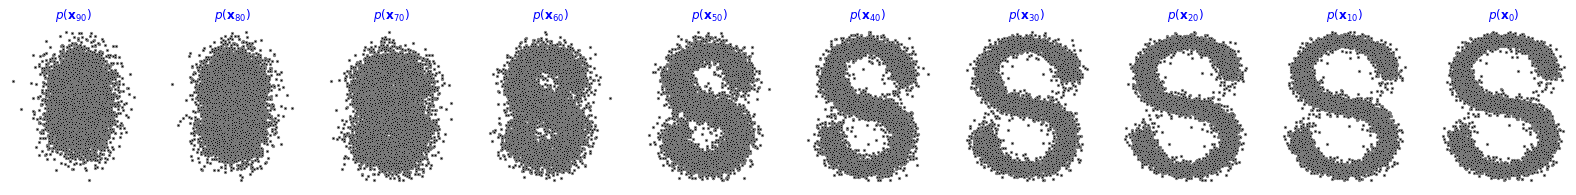

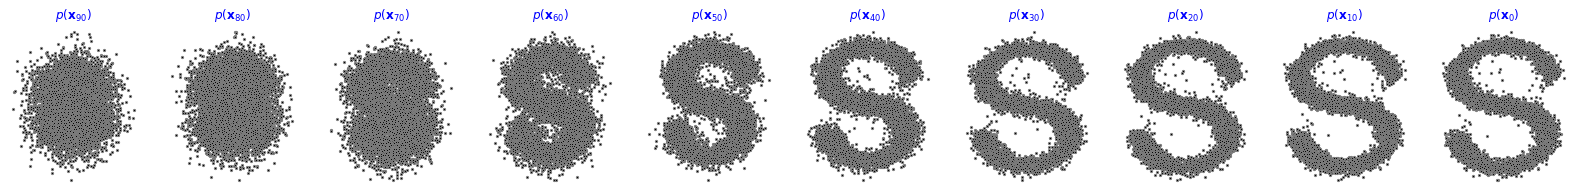

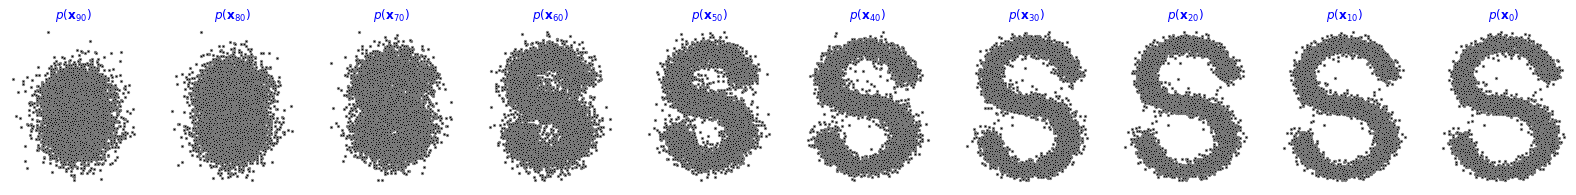

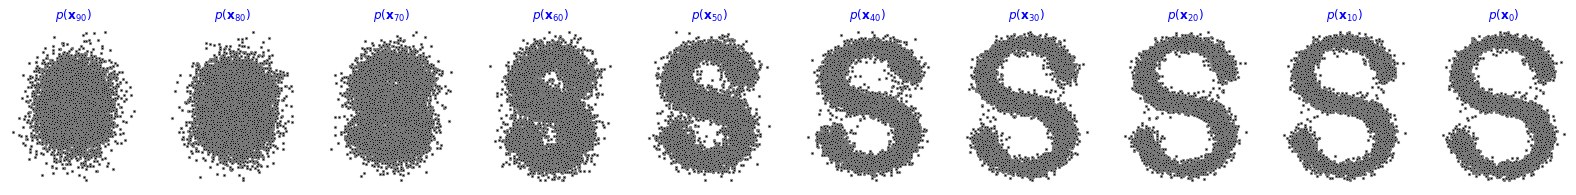

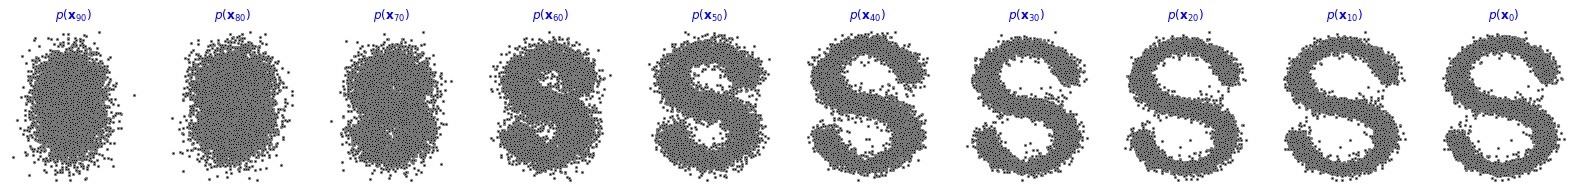

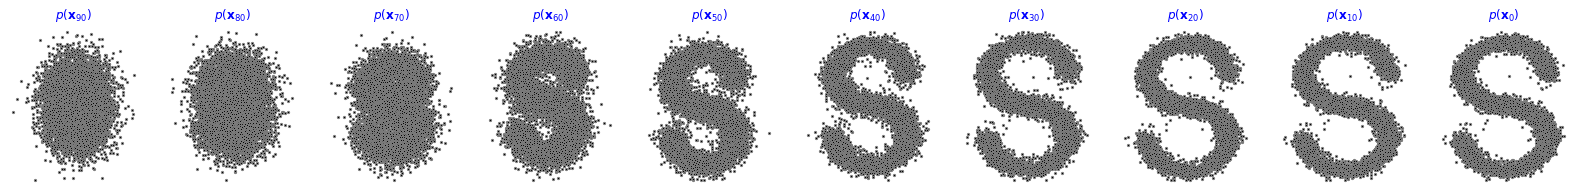

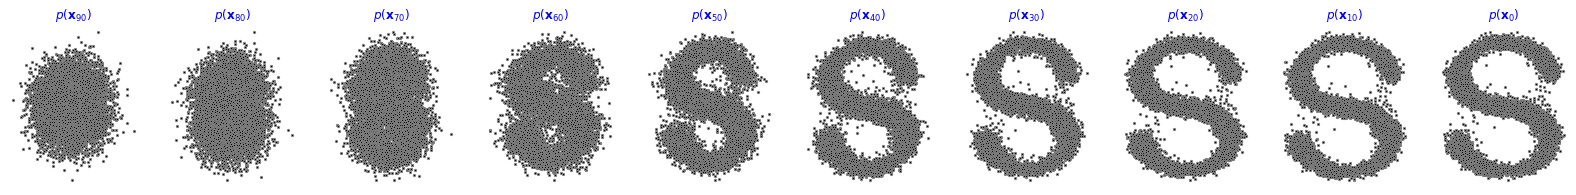

In [14]:
batch_size = 128
max_epoch = 1000
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
def train(model, optimizer, max_epoch=1000, batch_size=128):
    for epoch in range(max_epoch):
        for batch_x in dataloader:
            loss = diffusion_loss(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optimizer.step()

        if (epoch + 1) % 100 == 0:
            x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)
            fid = calculate_fid(x_seq[num_steps - 1].detach().cpu(),dataset.cpu())
            print(f"epoch:{epoch + 1}, loss:{loss.item():.6f}, fid:{fid:.6f}")

            fig, axs = plt.subplots(1, 10, figsize=(28, 3))
            for i in range(10):
                cur_x = x_seq[100 - 10 * (i + 1)].detach().cpu()
                axs[i].scatter(cur_x[:,0], cur_x[:,1], color='k', edgecolor='gray', s=5)
                axs[i].set_axis_off()
                axs[i].set_title('$p(\mathbf{x}_{' + str(100 - 10 * (i + 1))+'})$')
    return x_seq
x_seq = train(model, optimizer, max_epoch, batch_size)

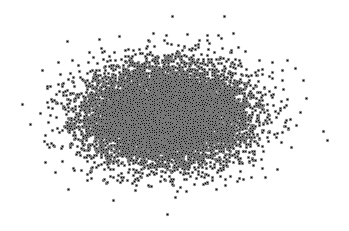

In [18]:
import io
from PIL import Image

process = []
for i in range(0, 100, 2):
    plt.clf()
    q_i = q_sample(dataset, torch.tensor([i]), alphas_bar_sqrt, one_minus_alphas_bar_sqrt).cpu()
    plt.scatter(q_i[:, 0], q_i[:, 1],color='k',edgecolor='gray', s=5)
    plt.axis('off')

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    process.append(img)

# Generating the reverse diffusion sequence

reverse = []
for i in range(0, 100, 2):
    plt.clf()
    cur_x = x_seq[i].detach().cpu()
    plt.scatter(cur_x[:, 0], cur_x[:, 1],color='k',edgecolor='gray', s=5)
    plt.axis('off')

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)
reverse.reverse()

In [16]:
imgs = process + reverse
imgs[0].save("./out/animation.gif", format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)